In [4]:
#IMPORT REQUIRED PACKAGES
import tensorflow as tf
from tensorflow import keras
import CO2_functions
import CO2_Processing
import pandas as pd
from CO2_functions import *
from CO2_Processing import *
import matplotlib.pyplot as plt
import pickle
import numpy as np
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import os
from keras.models import model_from_json
import json
from keras.wrappers.scikit_learn import KerasRegressor
#from mpi4py import MPI
#import sys
#sys.path.append('scikit-learn-mpi-grid-search/')

#from grid_search import NestedGridSearchCV

In [16]:
#Get data from local folder
df = pd.read_pickle('PN4_10S_downsample.pkl') # This is data resampled at 100 seconds

In [17]:
#Can resample to reduce size, '10T' is 10 minutes. 
df = df.resample('10T').mean()

In [18]:
#TIME LAG
df_to_use = df

n_seconds = 1 #how many periods to lag
n_features= len(df_to_use.columns)-1 #how many features exist in the feature matrix (number of cols - target col)
time_lagged = series_to_supervised(df_to_use,n_in=0,n_out=n_seconds,dropnan=False) #lag function (source CO2_Processing)
time_lagged_reframed = delete_unwanted_cols(time_lagged) #delete unneccesary columns (source CO2_Processing)


#Make mass flux at t the last column
loc = time_lagged_reframed.columns.get_loc('m_dot(t)')
cols = time_lagged_reframed.columns.tolist()
cols = cols[0:loc]+cols[(loc+1):]+[cols[loc]]
time_lagged_reframed = time_lagged_reframed[cols]

time_lagged_reframed.head()

,Pic_CO2(t),ANEM_Y(t),ANEM_X(t),ANEM_Z(t),wd(t),ws(t),m_dot(t)
Corrected_DT,,,,,,,
2019-09-23 23:50:00,412.719424,0.293673,-0.863157,-0.089371,107.867061,1.220688,NaN
2019-09-24 00:00:00,408.903182,0.734076,-0.894706,-0.108683,128.602091,1.265305,NaN
2019-09-24 00:10:00,408.054774,-0.042001,-0.987472,-0.102193,87.937770,1.396497,NaN
2019-09-24 00:20:00,409.918784,-0.395968,-0.572994,-0.062359,54.732883,0.810336,NaN
2019-09-24 00:30:00,413.007693,-0.488290,-0.326527,-0.042163,94.512433,0.577338,NaN


In [23]:
#Setup ML Architecture

values = time_lagged_reframed.dropna().values #Convert to numpy for processing
min_max_scalar = preprocessing.MinMaxScaler() #setup scaling
values_scaled = min_max_scalar.fit_transform(values) #scale all values from 0 to 1

#Set train size. Because time is a factor, we do not choose randomly, but chronologically
percent_train = 0.7
train_size = int(len(values)*percent_train) 
train = values_scaled[:train_size,:]  #Get train/test arrays
test = values_scaled[train_size:,:]

X_train,y_train = train[:,:-1], train[:,-1] #Split into feature/target arrays: target array = m_dot(t) (last column)
X_test, y_test = test[:,:-1], test[:,-1]

#Store shapes prior to 3D reshape such that they can be "unreshaped" and unscaled for representative fit/test plotting
orig_X_train_shape = X_train.shape
orig_X_test_shape = X_test.shape
orig_y_train_shape = y_train.shape
orig_y_test_shape = y_test.shape

#Reshape time lagged arrays based on number of seconds lagged: 
# X shape = (rows,lagged features,columns)
# y shape = (rows,)
X_train = X_train.reshape((X_train.shape[0], n_seconds, n_features)) 
X_test = X_test.reshape((X_test.shape[0], n_seconds, n_features))

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(905, 1, 6) (905,) (388, 1, 6) (388,)


In [6]:
#Gridsearch Testing

#import the model builder as a module from py file (doesn't work otherwise for some reason)
from model_builder import create_model 

model = KerasRegressor(build_fn=create_model,verbose=10)

batch_size = [5,10,20]#,40,60,80,100,200]
epochs = [1,5,10,20]#,50,100
learn_rate = [0.001]#,0.01,0.1]
activation = ['softmax','relu']#,'tanh','sigmoid']
dropout_rate = [0.0,0.1,0.2,0.5]
neurons = [32,64]#,128]

param_grid = dict(batch_size=batch_size, epochs=epochs,learn_rate=learn_rate,activation=activation,dropout_rate=dropout_rate,neurons=neurons)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3,verbose=10)
grid_result = grid.fit(X_train, y_train,verbose=1)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 3 folds for each of 192 candidates, totalling 576 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   47.7s
[Parallel(n_jobs=-1)]: Done 153 tasks      | elapsed:   51.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   54.1s
[Parallel(n_jobs=-1)]: Done 201 tasks      | elapsed:   57.3s
[Parallel(n_jobs=-1)]: Done 226 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 253 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 309 tasks      | elapsed:  

Epoch 1/20
905/905 [==============================] - 2s 2ms/step - loss: 0.1198 - mean_squared_error: 0.1198
Epoch 2/20
905/905 [==============================] - 1s 919us/step - loss: 0.0795 - mean_squared_error: 0.0795
Epoch 3/20
905/905 [==============================] - 1s 941us/step - loss: 0.0746 - mean_squared_error: 0.0746
Epoch 4/20
905/905 [==============================] - 1s 1ms/step - loss: 0.0700 - mean_squared_error: 0.0700
Epoch 5/20
905/905 [==============================] - 1s 1ms/step - loss: 0.0657 - mean_squared_error: 0.0657
Epoch 6/20
905/905 [==============================] - 1s 1ms/step - loss: 0.0616 - mean_squared_error: 0.0616
Epoch 7/20
905/905 [==============================] - 1s 959us/step - loss: 0.0579 - mean_squared_error: 0.0579
Epoch 8/20
905/905 [==============================] - 1s 1ms/step - loss: 0.0542 - mean_squared_error: 0.0542
Epoch 9/20
905/905 [==============================] - 1s 968us/step - loss: 0.0515 - mean_squared_error: 0.0515
Ep

In [24]:
# LSTM Model Training

#Define some regression loss metrics:
# root mean squared error (rmse) for regression
def rmse(y_true, y_pred):
    from keras import backend
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))
# R^2 for regression
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

#Train Model
model = Sequential()
model.add(LSTM(128,activation='relu'))  
model.add(Dropout(0.2))
model.add(Dense(1,activation = 'sigmoid')) #Sigmoid activation for regression

opt = tf.keras.optimizers.Adam(lr=1e-3,decay=1e-5)

model.compile(loss='mse',optimizer=opt,metrics=["mean_squared_error", rmse, r_square]) #Compile model
history = model.fit(X_train,y_train,epochs=20,batch_size=20,validation_data=(X_test,y_test)) #Fit model and save history 

Train on 905 samples, validate on 388 samples
Epoch 1/20
905/905 [==============================] - 2s 2ms/step - loss: 0.1629 - mean_squared_error: 0.1629 - rmse: 0.3779 - r_square: -2.0291 - val_loss: 0.1255 - val_mean_squared_error: 0.1255 - val_rmse: 0.3339 - val_r_square: -16811792.0000
Epoch 2/20
905/905 [==============================] - 0s 382us/step - loss: 0.1083 - mean_squared_error: 0.1083 - rmse: 0.3113 - r_square: -72915.7812 - val_loss: 0.0965 - val_mean_squared_error: 0.0965 - val_rmse: 0.2913 - val_r_square: -7915164.0000
Epoch 3/20
905/905 [==============================] - 0s 355us/step - loss: 0.0858 - mean_squared_error: 0.0858 - rmse: 0.2626 - r_square: -64908.6016 - val_loss: 0.0922 - val_mean_squared_error: 0.0922 - val_rmse: 0.2693 - val_r_square: -4660256.0000
Epoch 4/20
905/905 [==============================] - 0s 330us/step - loss: 0.0815 - mean_squared_error: 0.0815 - rmse: 0.2417 - r_square: -0.7430 - val_loss: 0.0901 - val_mean_squared_error: 0.0901 - va

In [25]:
y_fit = model.predict(X_test) #fit to x_test

In [26]:
#Return to original data shape and scale
X_test_original_shape = X_test.reshape(orig_X_test_shape) #reshape from 3d time
y_test_original_shape = y_test.reshape(orig_y_test_shape) #reshape from 3d time 

merged_tests = np.concatenate((X_test_original_shape,y_test_original_shape[:,None]),axis=1) #concat X and y
unscaled_test = pd.DataFrame(min_max_scalar.inverse_transform(merged_tests)).iloc[:,-1] #unscale using declared scalar

y_fit_original_shape = y_fit.reshape(orig_y_test_shape)
merged_tests = np.concatenate((X_test_original_shape,y_fit_original_shape[:,None]),axis=1)
unscaled_fit = pd.DataFrame(min_max_scalar.inverse_transform(merged_tests)).iloc[:,-1]

#Put into pandas df
comparison = pd.concat([unscaled_test,unscaled_fit],axis=1)
comparison.columns = ['test','fit']

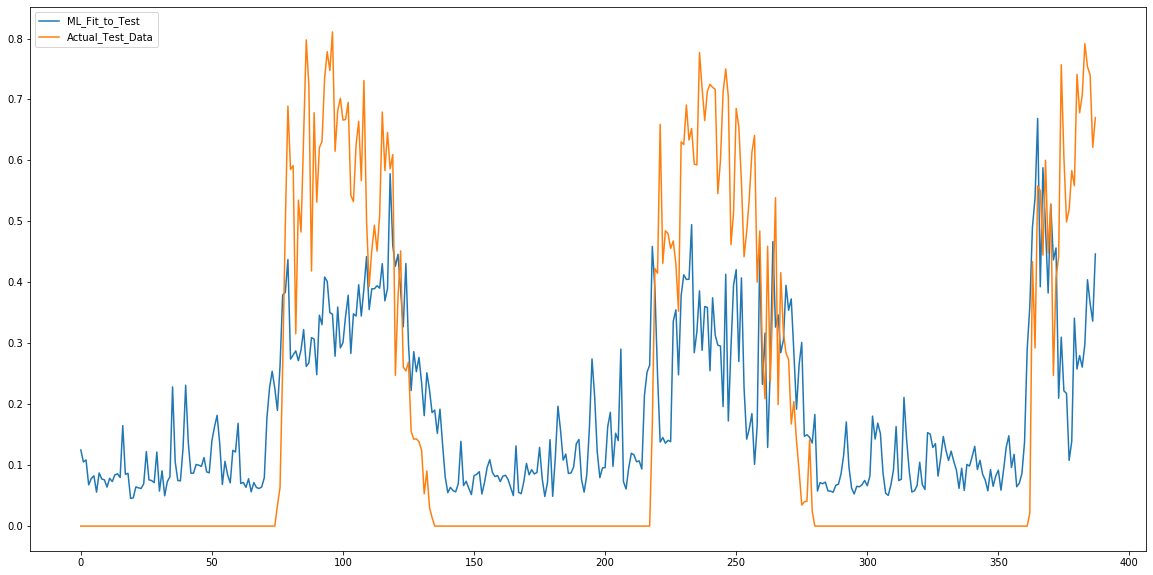

In [28]:
#PLOT PREDICTED VS OBSERVED
fig, ax = plt.subplots(figsize = (20,10))

#plot raw fit/test data (scaled)

ax.plot(y_fit,label='ML_Fit_to_Test')
ax.plot(y_test,label='Actual_Test_Data')


#plot unscaled fit/test data

# roll = 1
# ax.plot(comparison['fit'].rolling(roll).mean(),label='ML_Fit_to_Test')
# ax.plot(comparison['test'].rolling(roll).mean(),label='Actual_Test_Data')

ax.legend()
plt.show()